In [295]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import numpy as np
import time, re, datetime
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import zscore

from multiprocessing import Pool,cpu_count
num_processors = cpu_count()

print('Starting analysis; %d processors; %s' % (num_processors, datetime.datetime.today()))
t00 =time.time()

np.random.seed(0)

Starting analysis; 8 processors; 2020-03-10 20:13:22.618666


In [296]:
use_kmers = False
corr_type = 'Spearman';
corr_type = 'Pearson'

In [297]:
today=datetime.datetime.today().strftime('%d-%m-%Y')
# fn_load_prefix = 'RegressData/Regress_data_6143genes_19cells_'
# fn_load_prefix = 'RegressData/Regress_data_6174genes_20cells_'
fn_load_prefix = 'RegressData/Regress_data_9811genes_21cells_'

# Load datasets
save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu', 'genes']
# save_vars = ['rnau','genes']
for var in save_vars:
    fn = fn_load_prefix+var+'.pkl'
    cmd = '%s=pd.read_pickle("%s")' % (var, fn)
    exec(cmd)
    print('Loaded %s' % fn)

if use_kmers:
    with np.load(fn_load_prefix+'kmer_countsu.npz', allow_pickle=True) as x:
        kmer_countsu=x['kmer_countsu']
    kmer_countsu = kmer_countsu/kmer_countsu.shape[1]/100
    
    # Testing:
    kmer_countsu = kmer_countsu[:,:2]
    
    print('Kmers shape: ', kmer_countsu.shape)
    Nk=kmer_countsu.shape[1]
    print('Loaded kmers')
else:
    Nk=0

Loaded RegressData/Regress_data_9811genes_21cells_genes2enhu.pkl
Loaded RegressData/Regress_data_9811genes_21cells_rnau.pkl
Loaded RegressData/Regress_data_9811genes_21cells_df_mlevelu.pkl
Loaded RegressData/Regress_data_9811genes_21cells_df_atacu.pkl
Loaded RegressData/Regress_data_9811genes_21cells_genes.pkl


In [298]:
ngenes_use = 10000
genes = genes.iloc[np.random.permutation(genes.shape[0])[:ngenes_use],:]
genes2enhu = genes2enhu.iloc[[i in genes.index for i in genes2enhu['ensid']],:]
genes2enhu.index.unique().shape

(1916,)

In [299]:
features_use = 'mCG'
if (features_use=='mCG'):
    x = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()
elif (features_use=='ATAC'):
    x = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()
elif (features_use=='mCG_ATAC'):
    x1 = df_mlevelu.loc[genes2enhu['enh_pos'],:].to_numpy()
    x2 = df_atacu.loc[genes2enhu['enh_pos'],:].to_numpy()
    x = f_mcg(x1) * f_atac(x2)
else:
    x = []
    
y = rnau.loc[genes2enhu['ensid'],:].to_numpy()

In [300]:
def my_cc(x,y,ensid,doshuff=False,jshuff=0,corr_type='Pearson'):
    t0=time.time()
    ngenes,ncells = y.shape
    print('Computing correlations for %d gene-enhancer pairs; jshuff=%d; ' % (ngenes,jshuff))
    if doshuff:
#         y = y[:,np.random.permutation(ncells)]
        y = y[np.random.permutation(ngenes),:]
    if (corr_type=='Spearman'):
        y = np.argsort(y,axis=1)
        x = np.argsort(x,axis=1)
#     xy_cc = [np.abs(np.corrcoef(x1,y1)[0,1]) for (x1,y1) in zip(x,y)]
    xz = zscore(x, axis=1, nan_policy='omit', ddof=0)
    yz = zscore(y, axis=1, nan_policy='omit', ddof=0)
    xy_cc = np.abs(np.nanmean(xz*yz, axis=1))

    xy_cc_df = pd.DataFrame(data=xy_cc, index=ensid).groupby(by='ensid')
#     xy_cc_df['enh_num'] = np.arange(ngenes)
    best_cc = xy_cc_df.max().squeeze()
    if not doshuff:
        best_enh = xy_cc_df.idxmax()
    else:
        best_enh = []
    print('t=%3.3f' % (time.time()-t0))
    
    return best_cc,best_enh

In [301]:
best_cc,best_enh = my_cc(x,y,genes2enhu['ensid'],False,0,corr_type)

Computing correlations for 90478 gene-enhancer pairs; jshuff=0; 


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


t=0.580


In [302]:
nshuff = num_processors*16
np.random.seed(0)

t0=time.time()
with Pool(processes = num_processors) as p:
    best_cc_shuff_list = p.starmap(my_cc, [(x,y,genes2enhu['ensid'],True,jshuff,corr_type) for jshuff in range(nshuff)])
print('All done, t=%3.3f s' % (time.time()-t0))

Computing correlations for 90478 gene-enhancer pairs; jshuff=0; 


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


Computing correlations for 90478 gene-enhancer pairs; jshuff=4; 
t=0.103
Computing correlations for 90478 gene-enhancer pairs; jshuff=1; 


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


Computing correlations for 90478 gene-enhancer pairs; jshuff=8; 
t=0.106
Computing correlations for 90478 gene-enhancer pairs; jshuff=5; 
t=0.124
Computing correlations for 90478 gene-enhancer pairs; jshuff=2; 
Computing correlations for 90478 gene-enhancer pairs; jshuff=12; 


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


t=0.113
Computing correlations for 90478 gene-enhancer pairs; jshuff=6; 
t=0.135
Computing correlations for 90478 gene-enhancer pairs; jshuff=9; 
t=0.119
Computing correlations for 90478 gene-enhancer pairs; jshuff=3; 
Computing correlations for 90478 gene-enhancer pairs; jshuff=16; 


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


t=0.136
Computing correlations for 90478 gene-enhancer pairs; jshuff=13; 
t=0.107
Computing correlations for 90478 gene-enhancer pairs; jshuff=7; 
Computing correlations for 90478 gene-enhancer pairs; jshuff=20; 
t=0.158
t=0.180
Computing correlations for 90478 gene-enhancer pairs; jshuff=10; 


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


t=0.152
Computing correlations for 90478 gene-enhancer pairs; jshuff=14; 
t=0.181
Computing correlations for 90478 gene-enhancer pairs; jshuff=17; 
t=0.144


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


Computing correlations for 90478 gene-enhancer pairs; jshuff=24; 
t=0.120
Computing correlations for 90478 gene-enhancer pairs; jshuff=21; 
t=0.187
Computing correlations for 90478 gene-enhancer pairs; jshuff=11; 
t=0.147
Computing correlations for 90478 gene-enhancer pairs; jshuff=18; 
t=0.156
Computing correlations for 90478 gene-enhancer pairs; jshuff=28; 
Computing correlations for 90478 gene-enhancer pairs; jshuff=15; 
t=0.116
Computing correlations for 90478 gene-enhancer pairs; jshuff=22; 


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


Computing correlations for 90478 gene-enhancer pairs; jshuff=32; 
t=0.193
Computing correlations for 90478 gene-enhancer pairs; jshuff=25; 
t=0.182
t=0.164
t=0.181


/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


Computing correlations for 90478 gene-enhancer pairs; jshuff=19; 
Computing correlations for 90478 gene-enhancer pairs; jshuff=36; 
t=0.185
Computing correlations for 90478 gene-enhancer pairs; jshuff=23; 
t=0.203
Computing correlations for 90478 gene-enhancer pairs; jshuff=29; 
t=0.183
Computing correlations for 90478 gene-enhancer pairs; jshuff=33; 
t=0.184
Computing correlations for 90478 gene-enhancer pairs; jshuff=26; 
Computing correlations for 90478 gene-enhancer pairs; jshuff=40; 
t=0.145
Computing correlations for 90478 gene-enhancer pairs; jshuff=37; 
t=0.173
t=0.154
t=0.174
Computing correlations for 90478 gene-enhancer pairs; jshuff=30; 
Computing correlations for 90478 gene-enhancer pairs; jshuff=44; 
t=0.172
Computing correlations for 90478 gene-enhancer pairs; jshuff=34; 
t=0.188
Computing correlations for 90478 gene-enhancer pairs; jshuff=27; 
t=0.166
Computing correlations for 90478 gene-enhancer pairs; jshuff=41; 
Computing correlations for 90478 gene-enhancer pairs; 

In [303]:
alpha = 0.05;
best_cc_shuff = np.hstack([b[0][:,np.newaxis] for b in best_cc_shuff_list])
best_cc_shuff_max = np.percentile(best_cc_shuff, 100*(1-alpha), axis=1)
best_cc_shuff_mean = best_cc_shuff.mean(axis=1)
sig = best_cc.squeeze()>best_cc_shuff_max

# alpha = 0.005;
# sig = best_cc.squeeze()>np.percentile(best_cc_shuff,100*(1-alpha))
fdr = (alpha*len(sig))/np.sum(sig)
fdr, np.sum(sig), len(sig)

(0.4455813953488373, 215, 1916)

Saved Plots/GenesCorr_mCG_10-03-2020_Pearson


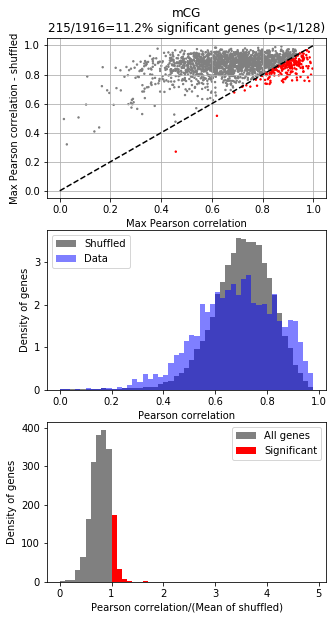

In [304]:
ngenes = best_cc.shape[0]

fig,axs=plt.subplots(3,1,figsize=(5,10))
plt.sca(axs[0])
# sig = best_cc>(best_cc_shuff_mean+3*best_cc_shuff_sd).squeeze()
plt.scatter(best_cc, best_cc_shuff_max,
            s=2,c=sig,
            cmap = ListedColormap(["gray",'red']))
plt.plot([0,1],[0,1],'k--')
plt.grid()
plt.xlabel('Max %s correlation' % corr_type)
plt.ylabel('Max %s correlation - shuffled' % corr_type)
plt.title('%s\n%d/%d=%3.1f%% significant genes (p<1/%d)' % (features_use, 
                                                            sig.sum(),ngenes,
                                                            100*sig.sum()/ngenes, nshuff))

plt.sca(axs[1])
plt.hist(best_cc_shuff.reshape(-1,1), bins=np.arange(0,1,0.02),density=True,color='gray',label='Shuffled');
plt.hist(best_cc.squeeze(), bins=np.arange(0,1,0.02),density=True,color='blue',label='Data',alpha=0.5);
# plt.hist(best_cc[sig], bins=np.arange(0,1,0.01),density=True,color='r',label='Significant');
plt.legend()
plt.xlabel(corr_type+' correlation')
plt.ylabel('Density of genes')


plt.sca(axs[2])
plt.hist(best_cc.squeeze()/best_cc_shuff_max.squeeze(), bins=np.arange(0,5,0.1),density=False,color='gray',
        label='All genes');
plt.hist(best_cc.squeeze()[sig]/best_cc_shuff_max.squeeze()[sig], bins=np.arange(0,5,0.1),density=False,color='red',
        label='Significant');
# plt.hist(best_cc, bins=np.arange(0,1,0.02),density=True,color='red',label='Data',alpha=0.5);
# plt.hist(best_cc[sig], bins=np.arange(0,1,0.01),density=True,color='r',label='Significant');
plt.xlabel(corr_type+' correlation/(Mean of shuffled)')
plt.ylabel('Density of genes')
plt.legend()

fn_plot = 'Plots/GenesCorr_%s_%s_%s' % (features_use, today, corr_type)
plt.savefig(fn_plot)
print('Saved %s' % fn_plot)

In [305]:
break

SyntaxError: 'break' outside loop (<ipython-input-305-6aaf1f276005>, line 4)

In [ ]:
np.savez('RegressData/GenesCorr_%s_%s.npz' % (features_use, today),
         best_cc=best_cc, best_cc_shuff=best_cc_shuff)
print('Saved data; t=%3.3f; %s' % (time.time()-t00, datetime.datetime.today()))

In [ ]:
today

In [ ]:
exit()

In [ ]:
# 1. Simplest model. Find the most predictive single enhancer for each gene.
from scipy.stats import zscore

ngenes = rna_lookup.shape[0]
ncells = rna_lookup.shape[1]
W_enh_gene = np.zeros((ngenes,ncells))

y = rna_lookup.copy()

def f_mcg(x):
    m0 = 0.2
    out = np.exp(-x/m0)
    return out

def f_atac(x):
    a0 = 0.1
    return x + a0

features_use = 'mCG_ATAC'
if (features_use=='mCG'):
    x = ml_lookup.copy()
elif (features_use=='ATAC'):
    x = atac_lookup.copy()
elif (features_use=='mCG_ATAC'):
    x=f_mcg(ml_lookup) * f_atac(atac_lookup)
else:
    x = []

In [ ]:
# For each gene find the correlation with each enhancer
from scipy.stats import spearmanr

def myCorr(x,y,doshuff=False,jshuff=0):    
    t0 = time.time()
    tot_time = 0;
    ngenes,nenh,ncells = x.shape
    xy_cc = np.zeros((ngenes, nenh))+np.nan
    use_enh = np.sum(x!=0,axis=2)
    
    if doshuff:
        # Randomize both the cell order and the gene order
        y=y[:,np.random.permutation(ncells)]
        y=y[np.random.permutation(ngenes),:]

    for j in range(nenh):
        curr_genes = use_enh[:,j]>0
        xy_cc[curr_genes,j] = [np.corrcoef(x1,y1)[0,1] for (x1,y1) in zip(x[curr_genes,j,:], y[curr_genes,:])]
#         xy_cc[curr_genes,j] = [spearmanr(x1,y1)[0] for (x1,y1) in zip(x[curr_genes,j,:], y[curr_genes,:])]
        
#         if ((time.time()-t0)>5) or (j==nenh-1):
    
    tot_time+=(time.time()-t0)
    print('%d/%d. Shuff %d. %d enhancers. t=%3.3f s' % (j,nenh,jshuff,np.sum(curr_genes),tot_time))
    t0=time.time()

    return xy_cc

In [ ]:
# Get correlation for real data
xy_cc = myCorr(x,y)

In [ ]:
# Get correlation for shuffled data. Run in parallel
nshuff = 50
np.random.seed(0)

#Create a pool of processors
t0=time.time()
with Pool(processes = num_processors) as p:
    xy_cc_shuff = p.starmap(myCorr, [(x,y,True,jshuff) for jshuff in range(nshuff)])
print('All done, t=%3.3f s' % (time.time()-t0))

In [ ]:
xy_cc_shuff = np.dstack(xy_cc_shuff)

In [ ]:
best_enh = np.argmax(np.abs(xy_cc),axis=1)
best_cc = np.nanmax(np.abs(xy_cc),axis=1)

best_cc_shuff = np.nanmax(np.abs(xy_cc_shuff),axis=1,keepdims=True)
best_cc_shuff_mean = best_cc_shuff.mean(axis=2)
best_cc_shuff_sd = best_cc_shuff.std(axis=2)
best_cc_shuff_max = best_cc_shuff.max(axis=2)

In [ ]:
from matplotlib.colors import ListedColormap

fig,axs=plt.subplots(3,1,figsize=(5,10))
plt.sca(axs[0])
# sig = best_cc>(best_cc_shuff_mean+3*best_cc_shuff_sd).squeeze()
sig = best_cc>best_cc_shuff_max.squeeze()
plt.scatter(best_cc, best_cc_shuff_mean,
            s=2,c=sig,
            cmap = ListedColormap(["gray",'red']))
plt.plot([0,1],[0,1],'k--')
plt.grid()
plt.xlabel('Max correlation')
plt.ylabel('Max correlation - shuffled')
plt.title('%s\n%d/%d=%3.1f%% significant genes (p<1/%d)' % (features_use, 
                                                            sig.sum(),ngenes,
                                                            100*sig.sum()/ngenes, nshuff))

plt.sca(axs[1])
plt.hist(best_cc_shuff_max, bins=np.arange(0,1,0.02),density=True,color='gray',label='Shuffled');
plt.hist(best_cc, bins=np.arange(0,1,0.02),density=True,color='blue',label='Data',alpha=0.5);
# plt.hist(best_cc[sig], bins=np.arange(0,1,0.01),density=True,color='r',label='Significant');
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Density of genes')


plt.sca(axs[2])
plt.hist(best_cc.squeeze()/best_cc_shuff_mean.squeeze(), bins=100,density=False,color='gray',
        label='All genes');
plt.hist(best_cc.squeeze()[sig]/best_cc_shuff_mean.squeeze()[sig], bins=100,density=False,color='red',
        label='Significant');
# plt.hist(best_cc, bins=np.arange(0,1,0.02),density=True,color='red',label='Data',alpha=0.5);
# plt.hist(best_cc[sig], bins=np.arange(0,1,0.01),density=True,color='r',label='Significant');
plt.xlabel('Correlation/(Mean of shuffled)')
plt.ylabel('Density of genes')
plt.legend()

plt.savefig('Plots/GenesCorr_%s_%s' % (features_use, today))

In [ ]:
# Show examples of most correlated genes
show = np.argsort(best_cc)[:10]
sig[show]

In [ ]:
def f_mcg(x):
    m0 = 0.2
    out = np.exp(-x/m0)
    return out

def f_atac(x):
    a0 = 0.1
    return x + a0

In [ ]:
ml_best = ml_lookup.reshape((ngenes*nenh, ncells))
ind = np.ravel_multi_index((np.arange(ngenes), best_enh), (ngenes,nenh))
ml_best = ml_best[ind,:]
# ml_bestz = zscore(ml_best,axis=1)
# yz = zscore(y,axis=1)

# plt.plot(ml_bestz[:100,:], yz[:100,:],'.');
ml_best.shape, best_enh
ml_lookup[0,7,:]

In [ ]:
x = np.random.randn(5,10)
x = np.pad(x,((0,0),(0,0),(1,0)),constant_values=1)
y = np.random.randn(5,10)

def my_regress(x,y):
#     b =  np.dot(np.linalg.pinv(np.dot(x,x.T)),np.dot(x,y.T))
    b =  np.linalg.pinv(np.dot(x,x.T)) * np.dot(x,y.T)
    print(x.shape, np.dot(x,x.T).shape, np.dot(x,y.T).shape)
    return b

my_regress(x,y)
?np.tensordot

In [ ]:
N_enh = np.zeros((ngenes,1))
mdl_score = np.zeros((ngenes,1))
mdl_score_shuff = np.zeros((ngenes,1))
y = np.zeros((ngenes,ncells))
yhat = np.zeros((ngenes,ncells))
yhat_shuff = np.zeros((ngenes,ncells))
t0 = time.time()
rand_cells = np.random.permutation(np.arange(ncells))

do_shuffle = False
for ensid in np.arange(ngenes):
#     try:
    data = get_data_index([ensid])
    x = data['epi'].copy()
#     x = f_atac(x[:,:,:,1]) 
#     x += np.random.randn(*x.shape)*0.00001 # Add a small noise term to avoid NaN in the zscore
    x = f_mcg(x[:,:,:,0]) * f_atac(x[:,:,:,1])
    x = x.squeeze().T

    x = zscore(x, axis=0)
    data['y'] = zscore(data['y'].T).T

    # Regress rna against x
    mdlf = mdl.fit(x, data['y'].T)
    nenh = x.shape[1]
    W_enh_gene[ensid,:nenh] = mdlf.coef_
    N_enh[ensid] = nenh
    mdl_score[ensid] = mdlf.score(x, data['y'].T)
    y[ensid,:] = data['y']
    yhat[ensid,:] = mdlf.predict(x)

    # Shuffled
    data['y'] = data['y'][0,rand_cells]
    mdlf = mdl.fit(x, data['y'].T)
    mdl_score_shuff[ensid] = mdlf.score(x, data['y'].T)
    yhat_shuff[ensid,:] = mdlf.predict(x)
#     except:
#         print('Failed %d' % ensid)
    
print(time.time()-t0)

In [ ]:
# LASSO
from sklearn import linear_model
from scipy.stats import zscore

ngenes = rna_lookup.shape[0]
ncells = rna_lookup.shape[1]
lasso_alpha = 0.02
mdl = linear_model.Lasso(alpha=lasso_alpha, random_state=0)
W_enh_gene = np.zeros((ngenes,ml_lookup.shape[1]))
N_enh = np.zeros((ngenes,1))
mdl_score = np.zeros((ngenes,1))
mdl_score_shuff = np.zeros((ngenes,1))
y = np.zeros((ngenes,ncells))
yhat = np.zeros((ngenes,ncells))
yhat_shuff = np.zeros((ngenes,ncells))
t0 = time.time()
rand_cells = np.random.permutation(np.arange(ncells))

do_shuffle = False
for ensid in np.arange(ngenes):
#     try:
    data = get_data_index([ensid])
    x = data['epi'].copy()
#     x = f_atac(x[:,:,:,1]) 
#     x += np.random.randn(*x.shape)*0.00001 # Add a small noise term to avoid NaN in the zscore
    x = f_mcg(x[:,:,:,0]) * f_atac(x[:,:,:,1])
    x = x.squeeze().T

    x = zscore(x, axis=0)
    data['y'] = zscore(data['y'].T).T

    # Regress rna against x
    mdlf = mdl.fit(x, data['y'].T)
    nenh = x.shape[1]
    W_enh_gene[ensid,:nenh] = mdlf.coef_
    N_enh[ensid] = nenh
    mdl_score[ensid] = mdlf.score(x, data['y'].T)
    y[ensid,:] = data['y']
    yhat[ensid,:] = mdlf.predict(x)

    # Shuffled
    data['y'] = data['y'][0,rand_cells]
    mdlf = mdl.fit(x, data['y'].T)
    mdl_score_shuff[ensid] = mdlf.score(x, data['y'].T)
    yhat_shuff[ensid,:] = mdlf.predict(x)
#     except:
#         print('Failed %d' % ensid)
    
print(time.time()-t0)

In [ ]:
# plt.hist(mdl_score, bins=100);
W_nenh = (np.abs(W_enh_gene)>0).sum(axis=1)
W_pct_nenh = W_nenh / N_enh.squeeze()
W_nenh.shape, N_enh.shape, W_pct_nenh.shape

fig, axs = plt.subplots(1,3, figsize=(20,5), sharey=False)
plt.sca(axs[0])
plt.plot(W_pct_nenh, mdl_score, '.')
plt.xlabel('Fraction of enhancers used')
plt.ylabel('Model score')

plt.sca(axs[1])
plt.plot(W_nenh+0.1, mdl_score, '.')
# plt.xscale('log')
plt.xlabel('Num. of enhancers used')

plt.sca(axs[2])
plt.loglog(y+1e-5, yhat+1e-5, '.');
plt.grid()

In [ ]:
plt.plot(mdl_score, mdl_score_shuff, '.')
plt.plot([0,1],[0,1],'k')
plt.xlabel('R-squared for data')
plt.ylabel('R-squared for shuffled data')
plt.grid()

In [ ]:
from scipy.stats import spearmanr 
cc = [spearmanr(y[:,i], yhat[:,i])[0] for i in range(ncells)]
cc_shuff = [spearmanr(y[:,i], yhat_shuff[:,i])[0] for i in range(ncells)]
plt.plot(cc)
plt.plot(cc_shuff)
plt.xlabel('Cell type')
plt.ylabel('Spearman correlation')

In [ ]:
from scipy.stats import spearmanr 
cc = [spearmanr(y[:,i], yhat[:,i])[0] for i in range(ncells)]
plt.plot(cc)

In [ ]:
mdl_scorei = np.argsort(mdl_score.squeeze())[::-1]
mdl_scorei[:5]
for ensid in mdl_scorei[:5]:
    data = get_data_index([ensid])
    x = data['epi'].copy()
    x = f_mcg(x[:,:,:,0]) * f_atac(x[:,:,:,1])
    x = x.squeeze().T
    
    # Regress rna against x
    mdlf = mdl.fit(x, data['y'].T)
    yhat = mdlf.predict(x)
    curr_nw = (mdlf.coef_!=0).sum()
    curr_gene = genes.loc[rnau.index[ensid],'gene']
    plt.loglog(data['y'].T, yhat, '.', label='%s (%d)' % (curr_gene,curr_nw))
plt.grid()
plt.legend()

In [ ]:
mdlf.coef_.shape

In [ ]:
today=datetime.datetime.today().strftime('%d-%m-%Y')
fn_load_prefix = 'RegressData/Regress_data_9868genes_21cells_'
fn_id = len(glob.glob('./RegressEnh*.pt'))+1 # Generate a unique ID for this run
fn_save = 'RegressEnh%0.4d_%s_N_%d_%d.%s.pt' % (fn_id, ('UseKmers' if use_kmers else 'NoKmers'), N1,N2,today)
fn_save, fn_id

In [ ]:
Nc = ml_lookup.shape[2]
def get_data_index(ensid_index):
    # For a list of ensids, return the x and y features
    Ng = len(ensid_index)
    mlu = ml_lookup[ensid_index,:,:] # Ngenes x Ne x Nc
    atacu = atac_lookup[ensid_index,:,:]
    if use_kmers:
        nz = np.max([len(kmeri_lookup[x]) for x in ensid_index])
        kmeru = np.zeros((Ng,nz,1,Nk))
        for i,ens in enumerate(ensid_index):
            kmeru[i,:len(kmeri_lookup[ens]),0,:] = kmer_countsu[kmeri_lookup[ens],:]
        kmeru = np.broadcast_to(kmeru, (Ng,nz,Nc,Nk))
    else:
        nz = np.sum((np.sum(atacu>0,axis=(0,2))+np.sum(mlu>0,axis=(0,2)))>0)
        kmeru = None

    # Keep only the enhancers that have data
    mlu = mlu[:,:nz,:,np.newaxis]
    atacu = atacu[:,:nz,:,np.newaxis]

    epi = np.concatenate((mlu,atacu),axis=3)
    y = rna_lookup[ensid_index,:]

#     # Test: add y to the input features
#     x[:,:,:,0] = y[:,np.newaxis,:]
    
#     # Testing:
#     for c in range(Nc):
#         y[:,c] = y[:,c]*0+c+0.123
    
    epi = torch.tensor(epi, dtype=torch.float)
    kmeru = torch.tensor(kmeru, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    
    return {'epi': epi, 'kmers': kmeru, 'y': y}

In [ ]:
Nc = ml_lookup.shape[2]

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1_kmers = nn.Linear(Nk, N1);
        self.fc1_epi = nn.Linear(2, N1);
        self.fc2 = nn.Linear(3*N1, N2);
        self.fc3 = nn.Linear(N2, 1);
        
    def forward(self, epi, kmers):
        if kmers.shape[0]>1:
            x = F.relu(self.fc1_kmers(kmers) + self.fc1_epi(epi)) # In: N x Eg x C x (2+K), Out: N x Eg x C x N1
        else:
            x = F.relu(self.fc1_epi(epi))

        # Collapse across enhancers in different ways
        xmax = torch.max(x, 1)[0]       # Out: N x C x N1
        xmean = torch.mean(x, 1)       # Out: N x C x N1
        xsum = torch.sum(x, 1)/10000       # Out: N x C x N1
        x = torch.cat((xmax,xmean,xsum),2) # Out: N x C x 3*N1

        x = F.relu(self.fc2(x))       # Out: N x C x N2
#         x = torch.reshape(x,(-1,N2*Nc)) # Out: N x C
#         x = self.fc3(x)
        x = self.fc3(x)
        x = torch.reshape(x,(-1,Nc))
        
        return x

In [ ]:
# Initialize
def myinit():
    global net, optimizer, criterion, scheduler, loss_test, loss_train, test, train, ensids
    net = Net()
    net.to(device)

    # Initialize the kmer weights to 0 and turn off learning
    net.fc1_kmers.requires_grad_(False)
    net.fc1_kmers.weight.fill_(0)
    net.fc1_kmers.bias.fill_(0)
    
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)
    
    loss_test=np.array([])
    loss_train = np.array([])

    # Train/Test split
    test = [c in ['chr10','chr12','chr14'] for c in rnau.join(genes)['chr']];
    train = [not i for i in test]

    test = np.random.permutation(np.nonzero(test)[0]).squeeze()
    train = np.random.permutation(np.nonzero(train)[0]).squeeze()
    ensids = rnau.index.values
    return

def train_epoch(epoch, phase=2):
    nsamp = 0
    running_loss = 0.0
    running_time = 0.0
    net.train()
    t0train = time.time()
    for i in range(0, len(train), batch_size):
        tstart = time.time()
        indices = train[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(indices)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers'] if phase==2 else torch.tensor([0.0])
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)
            batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_epi, batch_kmers)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_time += time.time()-tstart
        nsamp += len(indices)
        if (time.time()-t0train)>5:
            print('Epoch %d, i=%d/%d, LR=%3.5g, loss=%3.8f, t=%3.3f, %3.5f s/sample' % (epoch, i, len(train), 
                                                                                        optimizer.state_dict()['param_groups'][0]['lr'],
                                                                                        running_loss/nsamp, running_time, running_time/nsamp))
            t0train=time.time()

    return running_loss/nsamp

def test_epoch(epoch, phase=2):
    
    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(test), batch_size):
        indices = test[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(indices)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers'] if phase==2 else torch.tensor([0.0])
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)
            batch_y = batch_y.to(device)

        # forward + backward + optimize
        outputs = net(batch_epi, batch_kmers)
        loss = criterion(outputs, batch_y)
        running_loss_test += loss.item()
        nsamp += len(indices)

        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.detach().cpu().numpy())

    return running_loss_test/nsamp


In [ ]:
# %load_ext line_profiler
# batch_size = 2
# %lprun -f get_data_index testfn()

In [ ]:
# # %lprun -f get_data_index testfn()
# for batch_size in 2**np.arange(0,10):
#     print(batch_size)
#     myinit()
    
#     net.train()
#     %time testfn()

In [ ]:
def test_net(indices):
    net.eval()
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(indices), batch_size):
        i = indices[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(i)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers']
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)

        outputs = net(batch_epi, batch_kmers)
        
        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.numpy())
    yyhat['yhat'] = np.concatenate(yyhat['yhat'],axis=0)
    yyhat['y'] = np.concatenate(yyhat['y'],axis=0)
    
    cc = np.zeros((Nc,1))
    for i in range(yyhat['y'].shape[1]):
        cc[i,0] = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]    

    return yyhat, cc

def make_plot1(save=False):
    plt.figure(figsize=(15,4))
    plt.clf()
    plt.subplot(1,3,1)
    plt.semilogx(loss_train[2:],'o-',label='Train')
    plt.plot(loss_test[2:],'o-',label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(fn_save)

    plt.subplot(1,3,2)
    plt.plot(yyhat_test['y'].T, yyhat_test['yhat'].T,'.');
    plt.plot([0,3],[0,3],'k--')
    plt.xlabel('True RNA expression')
    plt.ylabel('Estimated RNA expression')

    plt.subplot(1,3,3)
    try:
        ccu = np.stack(train_hist['cc'],axis=2)
        plt.plot(train_hist['epoch'], ccu[:,0,:].mean(axis=0), 'ko-', label='train')
        plt.plot(train_hist['epoch'], ccu[:,1,:].mean(axis=0), 'ro-', label='test')

        plt.ylabel('Correlation coef.')
        plt.xlabel('Epoch')
        plt.legend()
    except:
        print('Skipping cc plot')
        
    if save:
        fn_plot = 'Plots/'+fn_save.replace('.torch','')+'_corrcoef.png'
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.show();
        
def make_plot2(save=False):
    plt.figure(figsize=(20,20))
    for i in range(Nc):
        plt.subplot(5,6,i+1)
        plt.plot([0,2],[0,2],'k--')
        plt.plot(yyhat_train['y'][:,i], yyhat_train['yhat'][:,i],'.');
        plt.plot(yyhat_test['y'][:,i], yyhat_test['yhat'][:,i],'.');
    #     cc = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]
        plt.title('r=%3.3f train/%3.3f test' % (cc[i,0], cc[i,1]))
    if save:
        fn_plot='Plots/'+fn_save.replace('.torch','')+'_scatter.png'
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.show();


In [ ]:
myinit()

In [ ]:
num_epochs1, num_epochs2 = 0, 200;

t0 = time.time()
batch_size = 2
train_hist = {'epoch': [], 'cc': []}
train_sample = random.sample(train.tolist(), 500)

for epoch in range(num_epochs1):  # loop over the dataset multiple times
    new_loss_train = train_epoch(epoch, phase=1);
    loss_train = np.append(loss_train, new_loss_train)
    
    new_loss_test = test_epoch(epoch, phase=1);
    loss_test = np.append(loss_test,new_loss_test)
    scheduler.step(new_loss_test)

    print('**** Phase1 epoch %d, LR=%3.5g, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (epoch, 
                    optimizer.param_groups[0]['lr'],
                    loss_train[-1], 
                    loss_test[-1], 
                    (time.time()-t0))
         )

    if (time.time()-t0)>20 or (epoch==num_epochs1-1):        
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_test': loss_test,
                }, fn_save)
        print('Saved data: %s' % fn_save)
        
        if (epoch>0):            
            cc = np.zeros((Nc,2))
            yyhat_train, cc[:,[0]] = test_net(train_sample)
            yyhat_test, cc[:,[1]] = test_net(test)
            display.clear_output(wait=True)
            make_plot1(save=True)
#             make_plot2(save=True)  
            display.display(plt.gcf())
        t0=time.time()
        
        train_hist['epoch'].append(epoch)
        train_hist['cc'].append(cc)


In [ ]:
batch_size = 2
t0 = time.time()

# Turn on the learning for kmers
net.fc1_kmers.requires_grad_(True)
# Reset the learning rate for the optimizer
optimizer = optim.Adam(net.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)

for epoch in np.arange(num_epochs1, num_epochs2+num_epochs1):  # loop over the dataset multiple times
    new_loss_train = train_epoch(epoch);
    loss_train = np.append(loss_train,new_loss_train)
    
    new_loss_test = test_epoch(epoch);
    loss_test = np.append(loss_test,new_loss_test)
    scheduler.step(new_loss_test)


    print('**** Phase2 epoch %d, LR=%3.5g, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (epoch, 
                    optimizer.param_groups[0]['lr'],
                    loss_train[-1], 
                    loss_test[-1], 
                    (time.time()-t0))
         )

    if (time.time()-t0)>20 or (epoch==num_epochs2-1):        
        if (epoch>1):            
            cc = np.zeros((Nc,2))
            yyhat_train, cc[:,[0]] = test_net(train_sample)
            yyhat_test, cc[:,[1]] = test_net(test)
            display.clear_output(wait=True)
            display.clear_output(wait=True)
            make_plot1(save=True)
#             make_plot2(save=True)  
            display.display(plt.gcf())
            t0=time.time()
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_test': loss_test,
                }, fn_save)
        print('Saved data: %s' % fn_save)  
        
        train_hist['epoch'].append(epoch)
        train_hist['cc'].append(cc)


In [ ]:
break

In [ ]:
batch_size = 2;
cc = np.zeros((Nc,2))
yyhat_train, cc[:,[0]] = test_net(random.sample(train.tolist(), 500))
yyhat_test, cc[:,[1]] = test_net(test)
make_plot1(save=True)
make_plot2(save=True)  

In [ ]:
break
# N = 64 x 32
# **** Epoch 39, LR=1e-05, loss_train=0.00182151, loss_test=0.00199540, time = 0.15510 s/epoch
# **** Epoch 0, LR=0.002, loss_train=6.51633886, loss_test=5.99391724, time = 19.92587 s/epoch

# N = 32 x 8
# **** Epoch 53, LR=1e-07, loss_train=0.00180459, loss_test=0.00203680, time = 0.12214 s/epoch
# **** Epoch 71, LR=0.00025, loss_train=0.00172845, loss_test=0.00188889, time = 0.09076 s/epoch


# N = 32 x 16
# **** Epoch 85, LR=0.000, loss_train=0.00167278, loss_test=0.00183274, time = 0.07683 s/epoch
# **** Epoch 65, LR=1e-06, loss_train=0.00168914, loss_test=0.00189639, time = 0.09208 s/epoch
# **** Epoch 53, LR=5e-07, loss_train=0.00172672, loss_test=0.00198197, time = 0.10991 s/epoch
# **** Epoch 58, LR=0.0005, loss_train=0.00167136, loss_test=0.00189098, time = 0.11401 s/epoch

# N = 16 x 8
# **** Epoch 53, LR=1e-05, loss_train=0.00177558, loss_test=0.00194236, time = 0.11628 s/epoch

# N = 4 x 4
# **** Epoch 66, LR=1.5625e-05, loss_train=0.00180230, loss_test=0.00197317, time = 0.09088 s/epoch


In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
2